# PDF Acquisition

In [1]:
#@title: Depandances for Scihub downloader
%%capture
!pip3 install -U scidownl


In [2]:
from scidownl import scihub_download
import pandas as pd
import os

In [6]:
ex = "doi.org/10.1145/3375633"
paper = input("Please enter the doi of the paper here: ")
paper_type = "doi"
out = "./paper.pdf"
proxies = {
    'http': 'socks5://127.0.0.1:7890'
}
scihub_download(paper, paper_type=paper_type, out=out)#, proxies=proxies)

Please enter the doi of the paper here: doi.org/10.1145/3375633


[INFO] | 2024/07/08 14:00:58 | Choose scihub url [0]: http://sci-hub.ru
[INFO] | 2024/07/08 14:00:58 | <- Request: scihub_url=http://sci-hub.ru, source=DoiSource[type=doi, id=doi.org/10.1145/3375633], proxies={}
[INFO] | 2024/07/08 14:00:59 | -> Response: status_code=200, content_length=7868
[INFO] | 2024/07/08 14:00:59 | * Extracted information: {'url': 'http://sci-hub.ru/downloads/2021-06-09/4a/beschastnikh2020.pdf', 'title': 'Visualizing Distributed System Executions. ACM Transactions on Software Engineering and Methodology, 29(2), 1–38'}


100% [==================================================] 2522115/2522115


[INFO] | 2024/07/08 14:01:01 | ↓ Successfully download the url to: ./one_paper2.pdf


In [ ]:
# prompt: Upload a file and rename it to paper.pdf, if the file is not a pdf file raise an error

from google.colab import files

uploaded = files.upload()

if not list(uploaded.keys())[0].endswith('.pdf'):
  raise ValueError('Uploaded file is not a pdf file.')

os.rename(list(uploaded.keys())[0], 'paper.pdf')


# Markdown Extraction with Marker

In [ ]:
#@title dependances
!pip install marker-pdf

In [ ]:
!marker_single /content/paper.pdf /content/output/ --batch_multiplier 2 --max_pages 10 --langs English

# Extracting the Methodology Section
**Objective:** Isolate the methodology section from the segmented markdown for further analysis.
- **Action Items:**
  - From the parsed sections, specifically extract the text under the "Methodology" heading.
  - Handle variations in heading titles like "Methods" or "Materials and Methods."


In [ ]:
import re

def extract_outline(file_path):
    outline = []
    with open(file_path, 'r') as file:
        for line in file:
            header_match = re.match(r'^(#+)\s+(.*)', line)
            if header_match:
                level = len(header_match.group(1))
                title = header_match.group(2)
                outline.append((header_match.group(1), title))
    return outline

def print_outline(outline):
    for hashes, title in outline:
        print(hashes + ' ' + title)

file_path = '/mnt/data/manuscript.md'
outline = extract_outline(file_path)
print_outline(outline)


In [1]:
# Prepare the outline variable
outline = """# Chapter One: Introduction and Literature Review
# Chapter Two: Materials and Methods
## Target Identification
## Control Selection
## Ligand Preparation
## Binding Site Identification and Grid Generation
## Molecular Docking
## Molecular Dynamics
# Chapter Three: Results
## Molecular Docking
## Molecular Dynamics
## ADME Properties Prediction
# Chapter Four: Discussion
## Binding Site Identification
## Molecular Docking
### Discussion for SP Docking Results:
### Discussion for XP Docking Results:
### Top Compound Discussion
## Molecular Dynamics
## ADME Properties Prediction
# Conclusion
# Recommendations
# References
# Appendices
# Citation"""


In [ ]:
%%capture
!pip install langchain
!pip install langchain_groq


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


In [8]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

In [18]:


# Create the payload with the outline and the prompt


chat = ChatGroq(
    temperature=0,
    model_name="llama3-8b-8192",
    max_tokens=50,
    groq_api_key=GROQ_API_KEY  # Optional if not set as an environment variable
)

system = """
###instructions###
You will receive an outline of a scientific paper in the format shown in the expected input. Extract and present only the highest level heading corresponding to the methods section, with no other output.

**Expected Input:**
#abstract
#introduction
#method
##method 1
#results
#conclusion

**Expected Output:**
#method

"""

text = f"""{outline}"""
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", text)])

chain = prompt | chat
response = chain.invoke({})
print(response.content)

# Chapter Two: Materials and Methods


In [ ]:
import re

def extract_section(file_path, section_title):
    section_content = []
    inside_section = False
    section_level = None

    with open(file_path, 'r') as file:
        for line in file:
            header_match = re.match(r'^(#+)\s+(.*)', line)
            if header_match:
                level = len(header_match.group(1))
                title = header_match.group(2)

                if inside_section:
                    if level <= section_level:
                        break
                if header_match.group(1) + ' ' + title == section_title:
                    inside_section = True
                    section_level = level

            if inside_section:
                section_content.append(line)

    return ''.join(section_content)


file_path = 'manuscript.md'
section_title = response.content
method = extract_section(file_path, section_title)

# Creating Methodology Graphs with Graphviz
**Objective:** Visualize the methodology section as a workflow graph.
- **Action Items:**
  - Install Graphviz in your Python environment.
  - Analyze the methodology text to identify key steps and their interconnections.
  - Design and implement a Graphviz script to create a diagram that represents these steps. This may involve defining nodes for each step and edges to show the sequence or relationship between them.
  - Ensure that the generated graph can be easily displayed within your Streamlit app or Google Colab notebook.

In [29]:
from graphviz import Digraph

dot = Digraph(comment='Materials and Methods')

# Adding nodes
dot.node('A', 'Target Identification')
dot.node('B', 'Control Selection')
dot.node('C', 'Ligand Preparation')
dot.node('D', 'Binding Site Identification and Grid Generation')
dot.node('E', 'Molecular Docking')
dot.node('F', 'Molecular Dynamics')

# Adding edges
dot.edge('A', 'B', 'Defines Control')
dot.edge('A', 'C', 'Inputs for Ligand Prep')
dot.edge('C', 'D', 'Prepared Ligands')
dot.edge('D', 'E', 'Grid Info & Ligands')
dot.edge('E', 'F', 'Selected Compounds')

# Render the output
dot.render('materials_methods_graph', format='png', view=True)
dot

'materials_methods_graph.png'

In [38]:
from graphviz import Digraph

dot = Digraph(comment='Research workflow on Lepidium sativum and blood glucose reduction')

dot.node('Literature Review', 'Analyze existing research')
dot.node('Target Identification', 'Select ABCC8 (Q14654)')
dot.node('Control Selection', 'Choose Repaglinide & Tolbutamide')
dot.node('Ligand Information Gathering', 'Retrieve ligand names and SMILES')
dot.node('Ligand Preparation', 'Prepare ligands with LigPrep')
dot.node('Binding Site Identification', 'Identify binding site on ABCC8 using SiteMap')
dot.node('Grid Generation', 'Generate receptor grid around binding site')
dot.node('Molecular Docking', 'Perform docking with Glide (SP mode)')
dot.node('Docking Score Selection', 'Select compounds with scores > -8.00')
dot.node('Molecular Dynamics Setup', 'Prepare system for MD simulations')
dot.node('System Definition', 'Define protein, water, ions, and ligand topologies')
dot.node('Equilibration', 'Equilibrate system for 1 ns')
dot.node('Production Run', 'Perform 5 ns production MD run')
dot.node('Results Analysis', 'Analyze MD simulation outcomes')

dot.edge('Literature Review', 'Target Identification', 'informs selection')
dot.edge('Target Identification', 'Control Selection', 'guides selection')
dot.edge('Literature Review', 'Ligand Information Gathering', 'guides identification')
dot.edge('Ligand Information Gathering', 'Ligand Preparation', 'uses information')
dot.edge('Ligand Preparation', 'Binding Site Identification', 'used for identification')
dot.edge('Binding Site Identification', 'Grid Generation', 'basis for grid')
dot.edge('Ligand Preparation', 'Molecular Docking', 'used in docking')
dot.edge('Molecular Docking', 'Molecular Dynamics Setup', 'selects compounds')
dot.edge('Molecular Dynamics Setup', 'Equilibration', 'prepares for equilibration')
dot.edge('Equilibration', 'Production Run', 'leads to production run')
dot.edge('Production Run', 'Results Analysis', 'provides outcomes')

dot.render('workflow', view=True)

'workflow.pdf'

In [46]:
#@title creation of nodes and edges

chat = ChatGroq(
    temperature=0,
    model_name="gemma2-9b-it",
    max_tokens=1024,
    groq_api_key=GROQ_API_KEY  # Optional if not set as an environment variable
)

system = """
Given a detailed method section from a research paper, your task is to identify and list out the main steps (nodes) and their dependencies (edges). Read through the method section carefully and:
- Identify key activities or processes described in each paragraph or significant sentence.
- Define each activity as a potential node in a graph.
- Determine how these nodes are connected by identifying the dependencies or the flow of information (inputs and outputs) between these steps.
- List each node along with a concise description.
- Map out the edges between these nodes, clearly describing the direction and the relationship (e.g., "provides input for," "depends on").
This will create a structured outline of nodes and edges, preparing for the visualization of this information in a flowchart or graph. Please provide a comprehensive list of all nodes and edges as extracted from the text.

### Example Output:

**Nodes:**
1. **Target Identification** - Investigate literature to identify the mechanism of Lepidium sativum in insulin secretion.
2. **Control Selection** - Select control drugs like Repaglinide and Tolbutamide for comparison.
3. **Ligand Preparation** - Retrieve ligand names and SMILES from literature and prepare using Schrödinger's Ligprep.
4. **Binding Site Identification and Grid Generation** - Identify binding site using SiteMap and generate docking grids with specified settings.
5. **Molecular Docking** - Perform docking of ligands and controls, selecting compounds with favorable docking scores.
6. **Molecular Dynamics** - Execute molecular dynamics simulations using specified settings and analyze the outcomes.

**Edges:**
- **From Target Identification to Control Selection** - Control drugs defined based on targets identified.
- **From Target Identification to Ligand Preparation** - Ligand information sourced based on identified targets.
- **From Ligand Preparation to Binding Site Identification and Grid Generation** - Prepared ligands are used to determine the docking site and grid parameters.
- **From Binding Site Identification and Grid Generation to Molecular Docking** - Grid settings and binding sites are utilized for docking.
- **From Molecular Docking to Molecular Dynamics** - Compounds selected from docking scores are used for dynamic simulations.
"""

text = f"""{method}"""
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", text)])

chain = prompt | chat
nande = chain.invoke({})


In [77]:
#@title writing the code for the graphviz

chat = ChatGroq(
    temperature=0,
    model_name="mixtral-8x7b-32768",
    max_tokens=1024,
    groq_api_key=GROQ_API_KEY  # Optional if not set as an environment variable
)

system = '''
### Instructions ###
Your task is to create a directed graph visualization based on nodes and edges extracted from the methodology section of a research paper using the Graphviz library in Python. Please follow these detailed steps:

1. Import the `graphviz` module.
2. Initialize a `Digraph` object to represent your directed graph.
3. Add each identified node to your graph using the `node` method. Assign a unique identifier to each node and a brief label that describes the step or component it represents.
4. Use the `edge` method to connect nodes. The connections should reflect the dependencies or relationships you mapped out from the paper. Optionally, add labels to the edges to further describe these relationships.
5. Adjust the graph's aesthetic properties as needed, such as changing the layout direction, node shape, or other visual attributes.
6. Render the graph and display it within your Jupyter notebook.

Please provide the complete Python code to execute these steps in a Jupyter notebook environment where the Graphviz library is already installed. The code should end with the graph being displayed directly in the notebook.

Example code for rendering and displaying the graph in a Jupyter notebook is also required. Make sure the graph is immediately viewable upon execution of the code."""

Here's an example Python code snippet that follows these instructions and includes Jupyter notebook display functionality:

```
from graphviz import Digraph
from IPython.display import display

# Initialize a Digraph object
dot = Digraph()

# Adding nodes with unique identifiers and descriptions
dot.node('A', 'Start')
dot.node('B', 'Step 1: Data Collection')
dot.node('C', 'Step 2: Data Cleaning')
dot.node('D', 'End')

# Adding edges with descriptions of the relationships
dot.edge('A', 'B', 'initiates')
dot.edge('B', 'C', 'follows')
dot.edge('C', 'D', 'concludes')

# Set graph aesthetic properties (optional)
dot.attr(rankdir='LR', size='10')

# Display the graph within the Jupyter notebook
display(dot)

```
'''

text = f"""{nande.content}"""
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", text)])

chain = prompt | chat
llm_response = chain.invoke({})


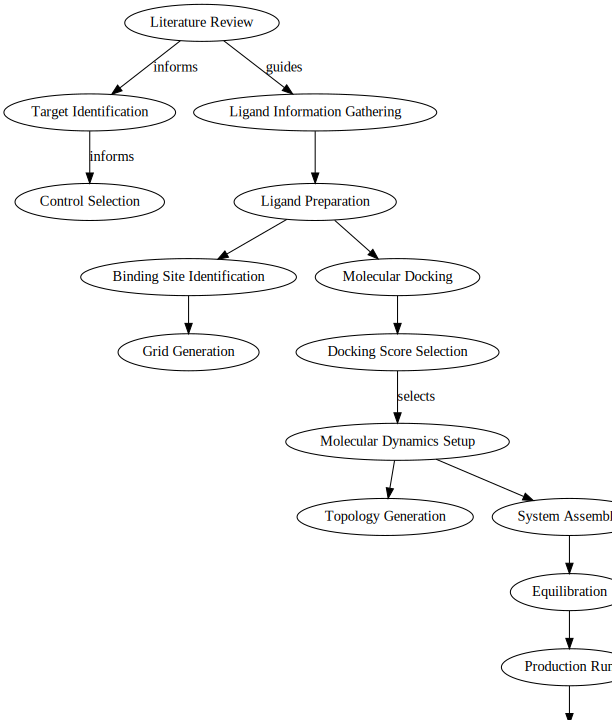

In [78]:
#@title extract the code form the response and run it
import re

def extract_code(llm_response):
    # Define the pattern to match the Python code block
    pattern = re.compile(r'```python(.*?)```', re.DOTALL)

    # Search for the code block
    match = pattern.search(llm_response)

    if match:
        # Extract the code
        code = match.group(1).strip()
        return code
    else:
        return "No Python code found in the response."

# Example LLM response
code = extract_code(llm_response.content)
exec(code)

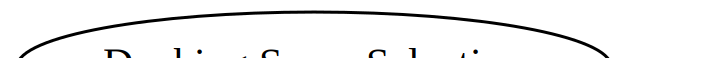

In [71]:
dot

In [66]:
!rm *

rm: cannot remove 'sample_data': Is a directory


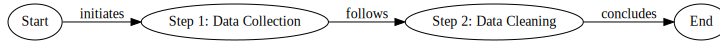

In [59]:
from graphviz import Digraph

# Initialize a Digraph object
dot = Digraph()

# Adding nodes with unique identifiers and descriptions
dot.node('A', 'Start')
dot.node('B', 'Step 1: Data Collection')
dot.node('C', 'Step 2: Data Cleaning')
dot.node('D', 'End')

# Adding edges with descriptions of the relationships
dot.edge('A', 'B', 'initiates')
dot.edge('B', 'C', 'follows')
dot.edge('C', 'D', 'concludes')

# Set graph aesthetic properties (optional)
dot.attr(rankdir='LR', size='10')

# Render and display the graph within the Jupyter notebook
dot